In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import traceback
from tqdm import tqdm
import numpy as np
import torch
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

/home/up/git-repo/newspaper-in-education/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import asyncioConfig as asyncC
from models.ClassifierInterface import ClassifierInterface
from requestsConfig import GetSession
from gdelt.GdeltConsumer import GdeltConsumer
from articleContent.ArticleConsumer import ArticleConsumer
from dataset import Dataset, TorchDatasetWrapper
from models.NieBert import NieBert

In [4]:
# Dependencies setup
session = GetSession()
gdeltConsumer = GdeltConsumer.getConsumer(session)
articleConsumer = ArticleConsumer.getConsumer(session)
asyncC.asyncioSetup()

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [5]:
# Splits a dataset to have at least lineCount lines, rounded up by one article
def TrainingDataset(fromDataset: Dataset, lineCount: int):
    trainingDataset = Dataset([])
    lines = 0
    i = 0
    while lines < lineCount and i < len(fromDataset):
        trainingDataset.append(fromDataset[i])
        lines+= len(fromDataset[i].content)
        i+=1
    return trainingDataset

def Predict(dataset: Dataset, classifier: ClassifierInterface, labels: list[int|float], splitAsSentences=False):
    if not labels:
        return
    if isinstance(labels[0], int):
        correct = 0
    
    error = 0
    squaredError = 0
    
    for i, article in enumerate(tqdm(dataset)):
        actual = labels[i]
        if actual == None:
            continue
        if not splitAsSentences: # Some models don't support it, and it defaults as false for those that supports it
            prediction = round(np.mean(classifier.predict(article)))
        else:
            prediction = round(np.mean(classifier.predict(article, splitAsSentences)))
        if isinstance(labels[0], int) and prediction == actual:
            correct += 1
        error += abs(actual - prediction)
        squaredError += abs(actual - prediction)**2
    
    if isinstance(labels[0], int):
        print(f'Correct predictions {correct}/{len(dataset)}, {(correct/len(dataset))*100}%')
    print(f'Error {error}, mean error {error/len(dataset)}')
    print(f'Root Mean Square Error {math.sqrt(squaredError/len(dataset))}')

In [6]:
def plot_regression_labels(labels):
    plt.figure(figsize=(8, 5))
    plt.hist(labels, bins=50, color='skyblue', edgecolor='black')
    plt.title("Label Distribution (Regression)")
    plt.xlabel("Label Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_regression_weights(labels):
    plt.figure(figsize=(8, 5))
    plt.hist(labels, bins=50, color='skyblue', edgecolor='black')
    plt.title("Weight Distribution (Regression)")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

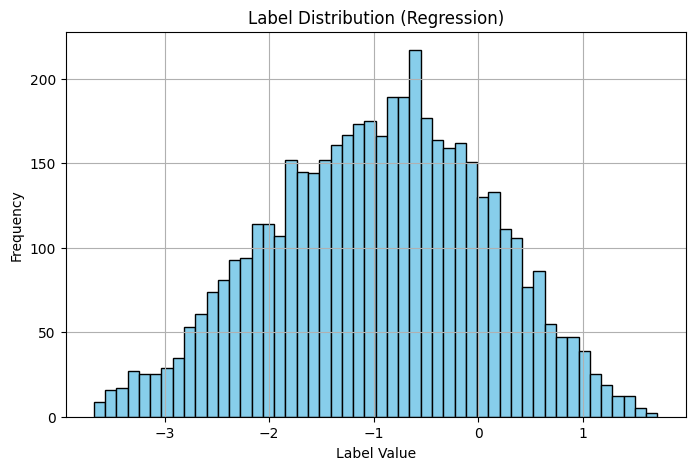

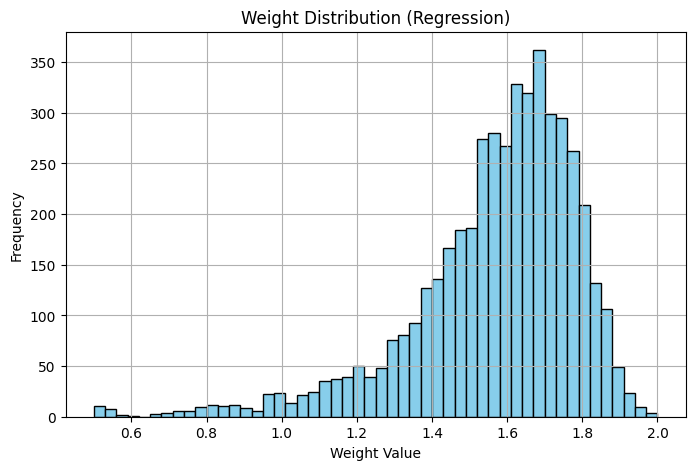

4723


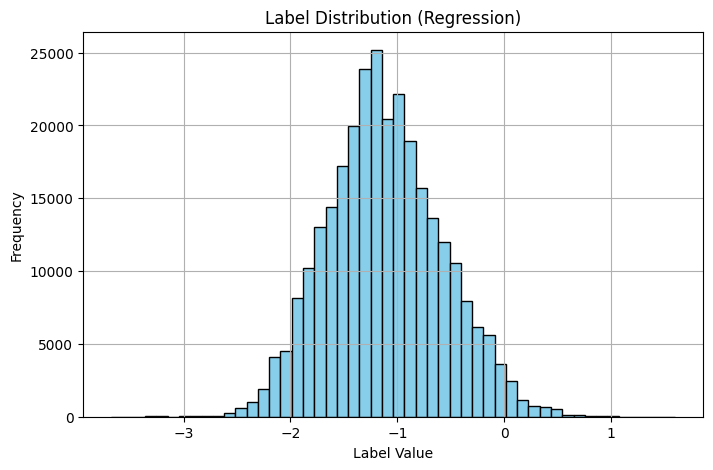

287188


In [ ]:
ds = Dataset.load('clearCorpus.json')
labels = NieBert.getRegressionLabels(ds)
plot_regression_labels(labels)
weights = NieBert.getRegressionWeights(ds)
plot_regression_weights(weights)
print(len(labels))
trainingDS = TorchDatasetWrapper.load('clearCorpus-bert-base-uncased-5.json', None)
labels = trainingDS.labels
plot_regression_labels(labels)
print(len(labels))

In [49]:
import copy


def main(
        modelNames = ['bert-base-uncased', 'roberta-large', 'google/electra-large-discriminator', 'microsoft/deberta-v3-large', 'albert-xxlarge-v2'],
        perDeviceTrainBatchSizes = [16, 4, 4, 8, 2],
        loadSaved=True,
        splitAsSentencesTraining=False,
        splitAsSentencesPredicting=False,
        nNeighbors=5
        ):
    
    ds = Dataset.load('clearCorpus.json')
    tds = TrainingDataset(ds, 30000)
    labels = NieBert.getRegressionLabels(ds)
    weights = NieBert.getRegressionWeights(ds)
    
    for mn, s in zip(modelNames, perDeviceTrainBatchSizes):
        labeler = None
        model = None
        trainingDS = None
        tokenizer = None
        if loadSaved:
            try:
                labeler = NieBert.load(f'{mn}-labeler'.replace('/', '-'))
                print(f'Labeler model {mn} loaded')
            except Exception:
                pass
            try:
                0/0
                model = NieBert.load(f'{mn}-{nNeighbors}'.replace('/', '-'))
                print(f'Model {mn} loaded')
                tokenizer = model.tokenizer
            except Exception:
                tokenizer = AutoTokenizer.from_pretrained(mn)
            try:
                trainingDS = TorchDatasetWrapper.load(f'clearCorpus-{mn}-{nNeighbors}.json'.replace('/', '-'), tokenizer)
                print(f'Torch dataset for {mn} loaded')
            except Exception:
                pass
        else:
            tokenizer = AutoTokenizer.from_pretrained(mn)

        validationDS = TorchDatasetWrapper.fromDataset(ds[len(tds):], labels[len(tds):], tokenizer, splitAsSentences= splitAsSentencesPredicting)
        
        try:
            wasNone = trainingDS == None
            if trainingDS == None:
                trainingDS = TorchDatasetWrapper.fromDataset(tds, labels[:len(tds)], tokenizer, weights[:len(tds)], splitAsSentences= splitAsSentencesTraining)
            
            if labeler == None:
                print(f'Now training {mn} as labeler')
                labeler = NieBert.trainFromTorchDataset(trainingDS, validationDS, mn, tokenizer, per_device_train_batch_size=s, gradient_accumulation_steps=(16//s))
                labeler.save(f'{mn}-labeler'.replace('/', '-'))
                print(f'Predictions for labeler (no pseudo-labeling) {mn}')
                Predict(ds[len(tds):], labeler, labels[len(tds):], splitAsSentencesPredicting)
            
            if wasNone:
                print(f'Extending dataset with pseudo-labeled records')
                trainingDS.addPseudoLabeledData('../external.csv', labeler, nNeighbors=nNeighbors)
                trainingDS.save(f'clearCorpus-{mn}-{nNeighbors}.json'.replace('/', '-'))

            if model == None:
                print(f'Now training {mn}')
                model = copy.deepcopy(labeler)
                model.retrain(trainingDS, validationDS, per_device_train_batch_size=s, gradient_accumulation_steps=(16//s))
                print(f'Saving model {mn}')
                model.save(f'{mn}-{nNeighbors}'.replace('/', '-'))

        except Exception as e:
            print(f'EXCEPTION for {mn}: {e}')
            traceback.print_exc()
            continue

        print(f'Predictions for {mn}')
        Predict(ds[len(tds):], model, labels[len(tds):], splitAsSentencesPredicting)

In [50]:
torch.cuda.empty_cache()

In [51]:
main(['bert-base-uncased'], [16], nNeighbors= 3)

Labeler model bert-base-uncased loaded
Extending dataset with pseudo-labeled records


100%|██████████| 170499/170499 [17:36<00:00, 161.36it/s]


Now training bert-base-uncased


Step,Training Loss,Validation Loss
50,0.040800,0.375382
100,0.041400,0.379090
150,0.034200,0.387194
200,0.034100,0.401969
250,0.036100,0.411198
300,0.044700,0.417942
350,0.032300,0.411277
400,0.042100,0.416125
450,0.036700,0.401324
500,0.036100,0.410045


Saving model bert-base-uncased
Predictions for bert-base-uncased


100%|██████████| 1700/1700 [00:16<00:00, 104.08it/s]

Error 946.1249370630013, mean error 0.5565440806252949
Root Mean Square Error 0.6937725260490278
